In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print(tf.test.gpu_device_name())


/device:GPU:0


In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from google.colab import drive

# Chemin du répertoire des images
path = '/content/drive/My Drive/Flipkart/Images'
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Approche 1 : dataset avec augmentation de données

In [7]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [8]:
import pathlib
path_2 = '/content/drive/My Drive/Flipkart/data_train/'
path_2_test = '/content/drive/My Drive/Flipkart/data_test/'

In [9]:
dataset_train = dataset_fct(path_2, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_2, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_2_test, validation_split=0, data_type=None)

Found 700 files belonging to 7 classes.
Using 525 files for training.
Found 700 files belonging to 7 classes.
Using 175 files for validation.
Found 350 files belonging to 7 classes.


In [10]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [11]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model

Avant de créer notre modèle de classification, nous allons d'abord visulaiser l'effet des différentes transformations sur une immage de data_train.

In [12]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

def apply_data_augmentation(image_path):
    # Chargement de l'image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Affichage de l'image d'origine
    plt.figure(figsize=(5, 5))
    plt.imshow(array_to_img(image.astype(np.uint8)))
    plt.title('Image originale')
    plt.axis('off')
    plt.show()

    # Data augmentation - RandomFlip
    flip = RandomFlip("horizontal", input_shape=(224, 224, 3))
    augmented_image_flip = flip(image[np.newaxis, ...])
    augmented_image_flip = array_to_img(augmented_image_flip[0], scale=False)

    # Affichage après RandomFlip
    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_image_flip)
    plt.title('Image après RandomFlip')
    plt.axis('off')
    plt.show()

    # Data augmentation - RandomRotation
    rotation = RandomRotation(0.1)
    augmented_image_rotation = rotation(image[np.newaxis, ...])
    augmented_image_rotation = array_to_img(augmented_image_rotation[0], scale=False)

    # Affichage après RandomRotation
    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_image_rotation)
    plt.title('Image après RandomRotation')
    plt.axis('off')
    plt.show()

    # Data augmentation - RandomZoom
    zoom = RandomZoom(0.1)
    augmented_image_zoom = zoom(image[np.newaxis, ...])
    augmented_image_zoom = array_to_img(augmented_image_zoom[0], scale=False)

    # Affichage après RandomZoom
    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_image_zoom)
    plt.title('Image après RandomZoom')
    plt.axis('off')
    plt.savefig('/content/drive/My Drive/Flipkart/Data_augmentation.png')
    plt.show()

    return image, augmented_image_flip, augmented_image_rotation, augmented_image_zoom


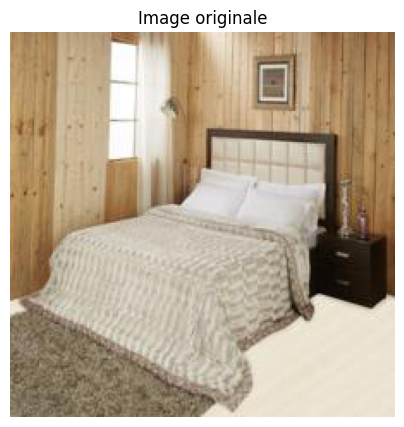

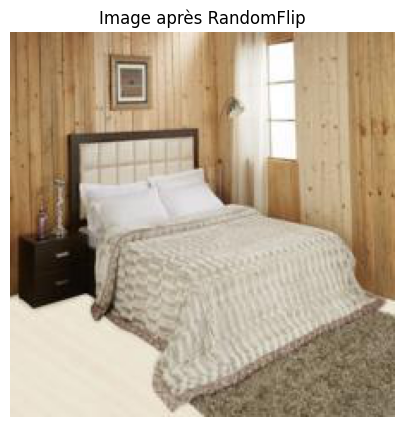

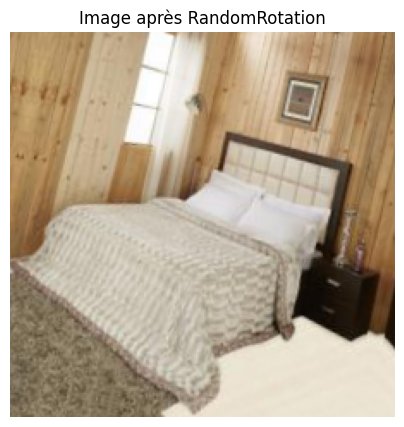

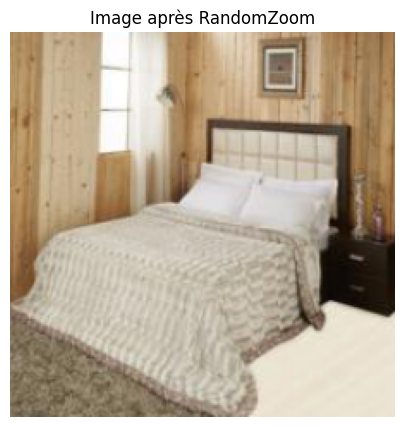

In [16]:
image_path = "/content/drive/My Drive/Flipkart/Images/ffc2e1fc7c886ec09a331040ada038aa.jpg"
original_image, image_flip, image_rotation, image_zoom = apply_data_augmentation(image_path)

In [18]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct2()

# Création du callback
model1_save_path = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 256)               

In [19]:
with tf.device('/gpu:0'):
    history1 = model1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=30, callbacks=callbacks_list, verbose=1)


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.8537 - accuracy: 0.2762
Epoch 1: val_loss improved from inf to 1.56565, saving model to ./model1_best_weights.h5
17/17 [==============================] - 124s 4s/step - loss: 1.8537 - accuracy: 0.2762 - val_loss: 1.5656 - val_accuracy: 0.4057
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.4466 - accuracy: 0.5238
Epoch 2: val_loss improved from 1.56565 to 1.17660, saving model to ./model1_best_weights.h5
17/17 [==============================] - 4s 196ms/step - loss: 1.4466 - accuracy: 0.5238 - val_loss: 1.1766 - val_accuracy: 0.6286
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.6476
Epoch 3: val_loss improved from 1.17660 to 0.91691, saving model to ./model1_best_weights.h5
17/17 [==============================] - 4s 223ms/step - loss: 1.1102 - accuracy: 0.6476 - val_loss: 0.9169 - val_accuracy: 0.7086
Epoch 4/30
17/17 [==============================] -

In [20]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

17/17 [==============================] - 3s 127ms/step - loss: 0.2385 - accuracy: 0.9314
Training Accuracy   : 0.9314

6/6 [==============================] - 1s 122ms/step - loss: 0.6537 - accuracy: 0.7600
Validation Accuracy :  0.7600


In [21]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7543
Test Accuracy       :  0.6486


In [22]:
!pip install plot_keras_history


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=0289494585033c9e040e8293c2511068ad6a2dc9c8b69b45e910e67a9e4c07ee
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=8c8eb7b78bb486c02fc9820f5a987c8846221cb4f38c12528869088ff998a29d
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=c7cfa7802c305fbd850b064c0197b65a60c3fb49eaa7c986166b123ab6cd7bdc
  Stored in director

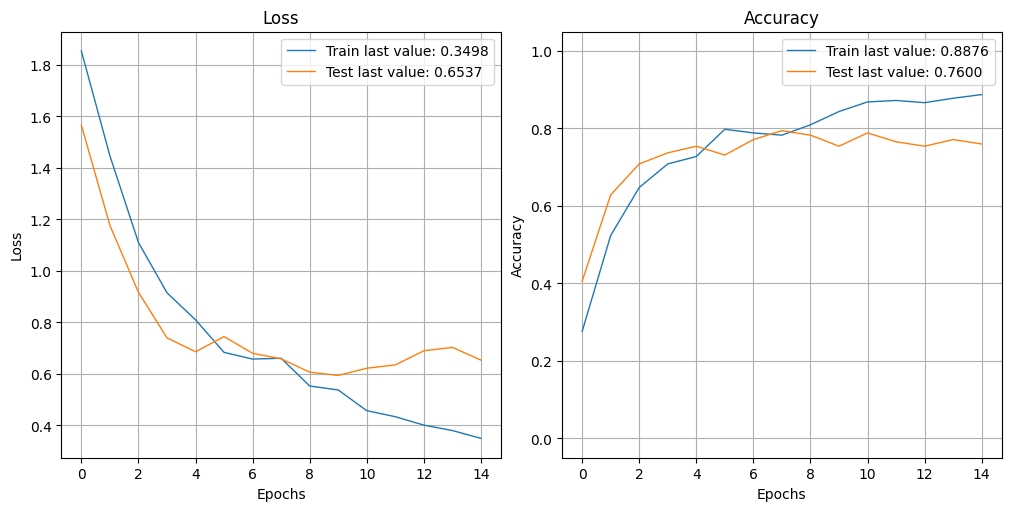

In [23]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.savefig('/content/drive/My Drive/Flipkart/Loss-Accuracy_model1.png')
plt.close()



In [ ]:
cat = ['Watches', 'Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']

1/1 [==============================] - 1s 799ms/step


'Kitchen & Dining'

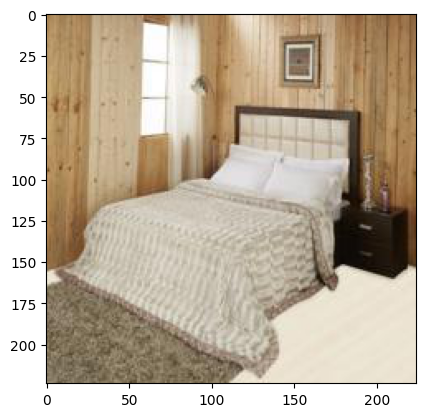

In [25]:
from tensorflow.keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/Flipkart/Images/ffc2e1fc7c886ec09a331040ada038aa.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
#from keras.models import load_model
#saved_model = load_model("vgg16_1.h5")
output = model1.predict(img)
cat[np.argmax(output)]

In [26]:
np.max(output)

0.9576082

# Approche 2 : approche par Dataset sans data augmentation

In [27]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [29]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
with tf.device('/gpu:0'):
    history2 = model2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 5.5922 - accuracy: 0.4648
Epoch 1: val_loss improved from inf to 1.93512, saving model to ./model2_best_weights.h5
17/17 [==============================] - 5s 214ms/step - loss: 5.5922 - accuracy: 0.4648 - val_loss: 1.9351 - val_accuracy: 0.7257
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.7356 - accuracy: 0.7486
Epoch 2: val_loss improved from 1.93512 to 1.71010, saving model to ./model2_best_weights.h5
17/17 [==============================] - 4s 202ms/step - loss: 1.7356 - accuracy: 0.7486 - val_loss: 1.7101 - val_accuracy: 0.7486
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.7829
Epoch 3: val_loss improved from 1.71010 to 1.46446, saving model to ./model2_best_weights.h5
17/17 [==============================] - 4s 226ms/step - loss: 1.1492 - accuracy: 0.7829 - val_loss: 1.4645 - val_accuracy: 0.7886
Epoch 4/50
17/17 [==============================] 

In [31]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

17/17 [==============================] - 2s 124ms/step - loss: 0.0244 - accuracy: 0.9905
Training Accuracy   : 0.9905

6/6 [==============================] - 1s 116ms/step - loss: 1.3157 - accuracy: 0.8286
Validation Accuracy :  0.8286


In [32]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8114
Test Accuracy       :  0.6143


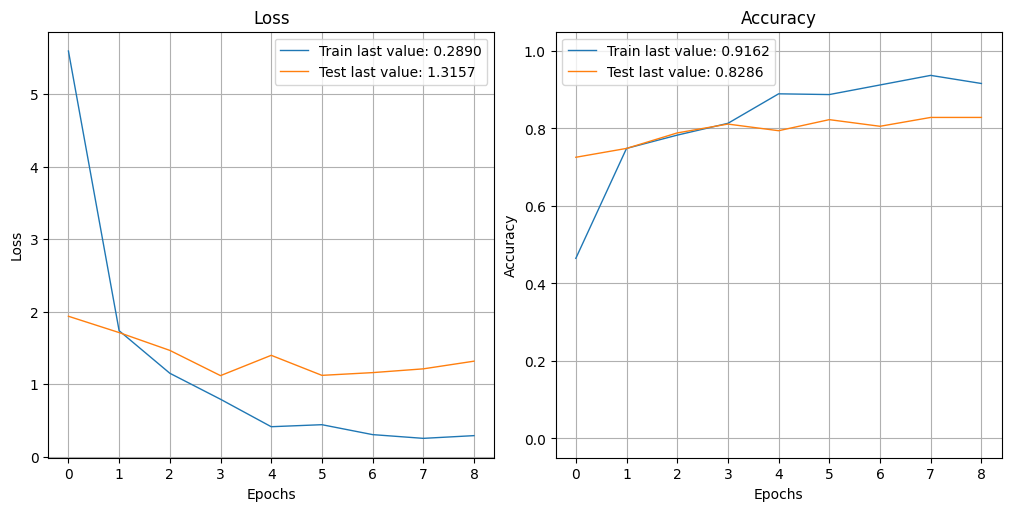

In [33]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.savefig('/content/drive/My Drive/Flipkart/Loss-Accuracy_model2.png')
plt.close()